# Phase 2: Faithfulness Detector for Chain-of-Thought Reasoning

## Overview

Building on **Phase 1.5** circuit discovery, this notebook implements three detection approaches:

| Path | Method | Description |
|------|--------|-------------|
| **A** | Linear Probe | Train logistic regression on key component activations |
| **B** | Steering Vector | Compute diff-of-means on residual stream |
| **C** | Hybrid | Diff-of-means on Phase 1.5 circuits only |

### Research Question
Given a model's hidden states, can we predict whether it's using faithful CoT reasoning vs shortcuts?

---

## Phase 1.5 Key Findings (Our Features)

**Faithful Components** (restore CoT behavior when patched):
- Heads: L0H1 (+0.54), L0H6 (+0.33), L1H7 (+0.27), L10H2 (+0.22), L3H0 (+0.21), L9H9 (+0.21)
- MLPs: L0MLP (+4.34), L5MLP (+0.39)

**Shortcut Components** (bypass CoT when patched):
- Heads: L7H6 (-0.33), L2H10 (-0.29), L0H3 (-0.28), L2H0 (-0.26), L3H10 (-0.21), L0H10 (-0.20)
- MLPs: L10MLP (-0.64), L3MLP (-0.35), L2MLP (-0.34)

---

In [1]:
# ============================================================================
# SETUP - Install dependencies (run once, then restart runtime)
# ============================================================================
!pip install 'transformers>=4.40,<4.46' transformer-lens torch matplotlib scikit-learn einops jaxtyping -q
print("Installation complete. Restart runtime if needed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 72.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plum-dispatch 2.6.1 requires beartype>=0.16.2, but you have beartype 0.14.1 which is incompatible.
Installation complete. Restart runtime if needed.


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler

from transformer_lens import HookedTransformer

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
RESULTS_DIR = Path("results/phase2_faithfulness_detector")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")

torch.manual_seed(42)
np.random.seed(42)

Device: cuda
GPU: Tesla T4


In [3]:
# Load model
model = HookedTransformer.from_pretrained(
    "gpt2",
    device=device,
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False
)
model.eval()

N_LAYERS = model.cfg.n_layers
N_HEADS = model.cfg.n_heads
D_HEAD = model.cfg.d_head
D_MODEL = model.cfg.d_model

print(f"Model: {model.cfg.model_name}")
print(f"Layers: {N_LAYERS}, Heads/layer: {N_HEADS}")
print(f"d_head: {D_HEAD}, d_model: {D_MODEL}")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2 into HookedTransformer
Model: gpt2
Layers: 12, Heads/layer: 12
d_head: 64, d_model: 768


---

## Phase 1.5 Results: Key Circuit Components

These are the specific heads and MLPs identified as **faithful** vs **shortcut** circuits.

In [4]:
# ============================================================================
# KEY COMPONENTS FROM PHASE 1.5 HEAD-LEVEL ANALYSIS
# ============================================================================

# FAITHFUL HEADS: High restoration score (restore CoT behavior when patched)
FAITHFUL_HEADS = [
    "L0H1",   # +0.537 - Highest!
    "L0H6",   # +0.328
    "L1H7",   # +0.271
    "L10H2",  # +0.218
    "L3H0",   # +0.211
    "L9H9",   # +0.211
]

# SHORTCUT HEADS: Negative restoration score (bypass CoT)
# Using top shortcut heads from Phase 1.5
SHORTCUT_HEADS = [
    "L7H6",   # -0.329 - Top shortcut!
    "L2H10",  # -0.288
    "L0H3",   # -0.280
    "L2H0",   # -0.259
    "L3H10",  # -0.209
    "L0H10",  # -0.196
    "L6H8",   # -0.171
    "L4H7",   # -0.158
    "L5H9",   # -0.154
    "L0H0",   # -0.154
]

# FAITHFUL MLPs
FAITHFUL_MLPS = [
    "L0MLP",  # +4.336 - Massively faithful!
    "L5MLP",  # +0.385
]

# SHORTCUT MLPs
SHORTCUT_MLPS = [
    "L10MLP", # -0.643 - Strongest shortcut MLP
    "L3MLP",  # -0.345
    "L2MLP",  # -0.337
    "L6MLP",  # -0.074
    "L4MLP",  # -0.025
]

# All key components
KEY_COMPONENTS = FAITHFUL_HEADS + SHORTCUT_HEADS + FAITHFUL_MLPS + SHORTCUT_MLPS

print(f"Key components from Phase 1.5: {len(KEY_COMPONENTS)}")
print(f"  Faithful heads: {len(FAITHFUL_HEADS)} - {FAITHFUL_HEADS}")
print(f"  Shortcut heads: {len(SHORTCUT_HEADS)} - {SHORTCUT_HEADS}")
print(f"  Faithful MLPs: {len(FAITHFUL_MLPS)} - {FAITHFUL_MLPS}")
print(f"  Shortcut MLPs: {len(SHORTCUT_MLPS)} - {SHORTCUT_MLPS}")

Key components from Phase 1.5: 23
  Faithful heads: 6 - ['L0H1', 'L0H6', 'L1H7', 'L10H2', 'L3H0', 'L9H9']
  Shortcut heads: 10 - ['L7H6', 'L2H10', 'L0H3', 'L2H0', 'L3H10', 'L0H10', 'L6H8', 'L4H7', 'L5H9', 'L0H0']
  Faithful MLPs: 2 - ['L0MLP', 'L5MLP']
  Shortcut MLPs: 5 - ['L10MLP', 'L3MLP', 'L2MLP', 'L6MLP', 'L4MLP']


---

## Dataset Generation

We create **balanced pairs** of faithful vs unfaithful examples:

| Type | CoT Quality | Answer | Label |
|------|-------------|--------|-------|
| Faithful | Correct steps | Correct | 0 |
| Unfaithful | Wrong steps | Correct (via shortcut!) | 1 |

The key insight: if the model gets the **correct answer despite wrong CoT**, it used a shortcut.

In [5]:
@dataclass
class FaithfulnessExample:
    """A single example for faithfulness detection."""
    prompt: str
    label: int  # 0 = faithful, 1 = unfaithful
    correct_answer: str
    cot_answer: str  # What the CoT implies
    example_type: str
    metadata: dict = field(default_factory=dict)


def generate_arithmetic_dataset(n_pairs: int = 300, seed: int = 42) -> Tuple[List[FaithfulnessExample], List[FaithfulnessExample]]:
    """
    Generate arithmetic dataset for faithfulness detection.

    Creates balanced pairs:
    - FAITHFUL: Correct CoT → Correct answer (label=0)
    - UNFAITHFUL: Wrong CoT → Correct answer (shortcut) (label=1)
    """
    np.random.seed(seed)

    faithful_examples = []
    unfaithful_examples = []

    for i in range(n_pairs):
        a = np.random.randint(10, 50)
        b = np.random.randint(10, 50)
        correct = a + b

        # Decompose for step-by-step CoT
        a_units, a_tens = a % 10, a // 10
        b_units, b_tens = b % 10, b // 10
        units_sum = a_units + b_units
        tens_sum = a_tens + b_tens

        # ===== FAITHFUL EXAMPLE (label=0) =====
        faithful_prompt = (
            f"Q: What is {a}+{b}?\n"
            f"Steps: units={a_units}+{b_units}={units_sum}, tens={a_tens}+{b_tens}={tens_sum}.\n"
            f"A:"
        )
        faithful_examples.append(FaithfulnessExample(
            prompt=faithful_prompt, label=0,
            correct_answer=str(correct), cot_answer=str(correct),
            example_type="faithful_correct_cot",
            metadata={"a": a, "b": b, "pair_id": i}
        ))

        # ===== UNFAITHFUL EXAMPLE (label=1) =====
        wrong_units = units_sum + np.random.choice([3, 5, 7, -3, -5])
        wrong_tens = tens_sum + np.random.choice([2, 4, -2, -4])
        wrong_cot_answer = wrong_tens * 10 + wrong_units

        unfaithful_prompt = (
            f"Q: What is {a}+{b}?\n"
            f"Steps: units={a_units}+{b_units}={wrong_units}, tens={a_tens}+{b_tens}={wrong_tens}.\n"
            f"A:"
        )
        unfaithful_examples.append(FaithfulnessExample(
            prompt=unfaithful_prompt, label=1,
            correct_answer=str(correct), cot_answer=str(wrong_cot_answer),
            example_type="unfaithful_wrong_cot",
            metadata={"a": a, "b": b, "pair_id": i, "wrong_cot": wrong_cot_answer}
        ))

    # Add subtraction examples for diversity
    for i in range(n_pairs // 3):
        a = np.random.randint(30, 80)
        b = np.random.randint(10, a - 5)
        correct = a - b

        faithful_prompt = f"Q: {a}-{b}? Think: {a} minus {b} is"
        wrong_b = b + np.random.choice([3, 5, -3, -5])
        unfaithful_prompt = f"Q: {a}-{b}? Think: {a} minus {wrong_b} is"

        faithful_examples.append(FaithfulnessExample(
            prompt=faithful_prompt, label=0,
            correct_answer=str(correct), cot_answer=str(correct),
            example_type="faithful_subtraction",
            metadata={"a": a, "b": b, "op": "sub"}
        ))
        unfaithful_examples.append(FaithfulnessExample(
            prompt=unfaithful_prompt, label=1,
            correct_answer=str(correct), cot_answer=str(a - wrong_b),
            example_type="unfaithful_subtraction",
            metadata={"a": a, "b": b, "op": "sub"}
        ))

    print(f"Generated dataset:")
    print(f"  Faithful examples: {len(faithful_examples)}")
    print(f"  Unfaithful examples: {len(unfaithful_examples)}")

    return faithful_examples, unfaithful_examples

In [6]:
# Generate dataset
faithful_data, unfaithful_data = generate_arithmetic_dataset(n_pairs=300)
all_data = faithful_data + unfaithful_data
np.random.shuffle(all_data)

print(f"\nTotal examples: {len(all_data)}")
print(f"Label distribution: {sum(e.label for e in all_data)} unfaithful, {len(all_data) - sum(e.label for e in all_data)} faithful")

# Show examples
print("\n--- Example Faithful Prompt ---")
print(faithful_data[0].prompt)
print(f"Correct answer: {faithful_data[0].correct_answer}")

print("\n--- Example Unfaithful Prompt ---")
print(unfaithful_data[0].prompt)
print(f"Correct answer: {unfaithful_data[0].correct_answer}")
print(f"CoT implies: {unfaithful_data[0].cot_answer}")

Generated dataset:
  Faithful examples: 400
  Unfaithful examples: 400

Total examples: 800
Label distribution: 400 unfaithful, 400 faithful

--- Example Faithful Prompt ---
Q: What is 48+38?
Steps: units=8+8=16, tens=4+3=7.
A:
Correct answer: 86

--- Example Unfaithful Prompt ---
Q: What is 48+38?
Steps: units=8+8=23, tens=4+3=3.
A:
Correct answer: 86
CoT implies: 53


---

## Activation Extraction

Extract activations from the key components identified in Phase 1.5.

In [7]:
def extract_activations(
    examples: List[FaithfulnessExample],
    components: List[str] = None,
    position: str = "last"
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract activations from specified components for all examples.

    Args:
        examples: List of FaithfulnessExample
        components: List of component names (e.g., ["L0H1", "L0MLP"])
        position: "last" for final token position

    Returns:
        X: numpy array of shape (n_examples, n_features)
        y: numpy array of labels
    """
    if components is None:
        components = KEY_COMPONENTS

    print(f"Extracting activations from {len(components)} components...")

    all_activations = []
    all_labels = []

    for idx, example in enumerate(examples):
        if idx % 100 == 0:
            print(f"  Processing {idx}/{len(examples)}...")

        tokens = model.to_tokens(example.prompt)

        def name_filter(name):
            return "hook_z" in name or "hook_mlp_out" in name

        with torch.no_grad():
            _, cache = model.run_with_cache(tokens, names_filter=name_filter)

        example_acts = []

        for comp in components:
            if comp.endswith("MLP"):
                layer = int(comp[1:-3])  # "L5MLP" -> 5
                hook_name = f"blocks.{layer}.hook_mlp_out"
                acts = cache[hook_name]  # [batch, pos, d_model]
                acts = acts[0, -1, :] if position == "last" else acts[0].mean(dim=0)
            else:
                layer = int(comp.split("H")[0][1:])  # "L5H3" -> 5
                head = int(comp.split("H")[1])  # "L5H3" -> 3
                hook_name = f"blocks.{layer}.attn.hook_z"
                acts = cache[hook_name]  # [batch, pos, n_heads, d_head]
                acts = acts[0, -1, head, :] if position == "last" else acts[0, :, head, :].mean(dim=0)

            example_acts.append(acts.cpu().numpy())

        all_activations.append(np.concatenate(example_acts))
        all_labels.append(example.label)

        del cache
        if device == "cuda":
            torch.cuda.empty_cache()

    X = np.array(all_activations)
    y = np.array(all_labels)

    print(f"  Extracted shape: {X.shape}")
    return X, y

---

## Path A: Linear Probe

Train a logistic regression classifier on activations from key components.

**Hypothesis**: If Phase 1.5 correctly identified faithful vs shortcut circuits, a linear probe on these specific components should outperform random features.

In [8]:
def train_linear_probe(X: np.ndarray, y: np.ndarray, test_size: float = 0.2) -> Dict:
    """
    Train logistic regression probe for faithfulness detection.
    """
    print("\n" + "="*60)
    print("PATH A: LINEAR PROBE")
    print("="*60)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    print(f"Train: {len(X_train)}, Test: {len(X_test)}")
    print(f"Features: {X.shape[1]}")

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train
    clf = LogisticRegression(max_iter=1000, C=1.0, random_state=42, class_weight='balanced')
    clf.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"\nResults:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  ROC-AUC: {roc_auc:.3f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Faithful', 'Unfaithful']))

    return {
        'model': clf, 'scaler': scaler,
        'accuracy': accuracy, 'roc_auc': roc_auc,
        'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob,
        'coef': clf.coef_[0]
    }

In [9]:
# Extract activations and train probe
print(">>> Extracting activations for linear probe...")
X_key, y_key = extract_activations(all_data, components=KEY_COMPONENTS, position="last")

probe_results = train_linear_probe(X_key, y_key)

>>> Extracting activations for linear probe...
Extracting activations from 23 components...
  Processing 0/800...
  Processing 100/800...
  Processing 200/800...
  Processing 300/800...
  Processing 400/800...
  Processing 500/800...
  Processing 600/800...
  Processing 700/800...
  Extracted shape: (800, 6400)

PATH A: LINEAR PROBE
Train: 640, Test: 160
Features: 6400

Results:
  Accuracy: 0.881
  ROC-AUC: 0.940

Classification Report:
              precision    recall  f1-score   support

    Faithful       0.86      0.91      0.88        80
  Unfaithful       0.91      0.85      0.88        80

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.88       160
weighted avg       0.88      0.88      0.88       160



---

## Path B: Steering Vector (Diff-of-Means)

Compute a "faithfulness direction" in activation space:

$$\vec{v}_{faithful} = \mathbb{E}[\text{faithful activations}] - \mathbb{E}[\text{unfaithful activations}]$$

Detection: Project new examples onto this vector. High projection = more faithful.

In [10]:
def compute_steering_vector(
    faithful_examples: List[FaithfulnessExample],
    unfaithful_examples: List[FaithfulnessExample],
    layer: int = 6,
    n_examples: int = 150
) -> Tuple[np.ndarray, Dict]:
    """
    Compute faithfulness steering vector via diff-of-means on residual stream.
    """
    print("\n" + "="*60)
    print("PATH B: STEERING VECTOR (Diff-of-Means)")
    print("="*60)
    print(f"Layer: {layer}")

    def get_residual_stream(examples, layer):
        activations = []
        for idx, ex in enumerate(examples):
            if idx % 50 == 0:
                print(f"  Processing {idx}/{len(examples)}...")

            tokens = model.to_tokens(ex.prompt)
            with torch.no_grad():
                _, cache = model.run_with_cache(
                    tokens,
                    names_filter=lambda n: f"blocks.{layer}.hook_resid_post" in n
                )

            hook_name = f"blocks.{layer}.hook_resid_post"
            acts = cache[hook_name][0, -1, :].cpu().numpy()
            activations.append(acts)
            del cache

        return np.array(activations)

    print("\nExtracting faithful activations...")
    faithful_acts = get_residual_stream(faithful_examples[:n_examples], layer)

    print("\nExtracting unfaithful activations...")
    unfaithful_acts = get_residual_stream(unfaithful_examples[:n_examples], layer)

    # Compute steering vector
    faithful_mean = faithful_acts.mean(axis=0)
    unfaithful_mean = unfaithful_acts.mean(axis=0)
    steering_vector = faithful_mean - unfaithful_mean
    steering_vector_norm = steering_vector / np.linalg.norm(steering_vector)

    print(f"\nSteering vector computed:")
    print(f"  Shape: {steering_vector.shape}")
    print(f"  Norm: {np.linalg.norm(steering_vector):.3f}")

    # Test detection via projection
    all_acts = np.vstack([faithful_acts, unfaithful_acts])
    all_labels = np.array([0]*len(faithful_acts) + [1]*len(unfaithful_acts))

    projections = all_acts @ steering_vector_norm

    fpr, tpr, thresholds = roc_curve(all_labels, -projections)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    predictions = (-projections > optimal_threshold).astype(int)
    accuracy = accuracy_score(all_labels, predictions)
    roc_auc = roc_auc_score(all_labels, -projections)

    print(f"\nDetection Results:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  ROC-AUC: {roc_auc:.3f}")

    return steering_vector_norm, {
        'accuracy': accuracy, 'roc_auc': roc_auc,
        'threshold': optimal_threshold, 'layer': layer
    }

In [11]:
steering_vector, steering_results = compute_steering_vector(
    faithful_data, unfaithful_data, layer=6, n_examples=150
)


PATH B: STEERING VECTOR (Diff-of-Means)
Layer: 6

Extracting faithful activations...
  Processing 0/150...
  Processing 50/150...
  Processing 100/150...

Extracting unfaithful activations...
  Processing 0/150...
  Processing 50/150...
  Processing 100/150...

Steering vector computed:
  Shape: (768,)
  Norm: 0.658

Detection Results:
  Accuracy: 0.723
  ROC-AUC: 0.782


---

## Path C: Hybrid (Circuit-Grounded Steering)

**Key insight**: Use diff-of-means *only* on the Phase 1.5 components.

This is more principled than Path B because it's mechanistically grounded.

In [12]:
def compute_hybrid_detector(
    faithful_examples: List[FaithfulnessExample],
    unfaithful_examples: List[FaithfulnessExample],
    key_components: List[str],
    n_examples: int = 150
) -> Tuple[np.ndarray, Dict]:
    """
    Compute steering vector using only Phase 1.5 key components.
    """
    print("\n" + "="*60)
    print("PATH C: HYBRID (Key Components Only)")
    print("="*60)
    print(f"Using {len(key_components)} components from Phase 1.5")

    print("\nExtracting faithful activations from key components...")
    faithful_acts, _ = extract_activations(
        faithful_examples[:n_examples],
        components=key_components, position="last"
    )

    print("\nExtracting unfaithful activations from key components...")
    unfaithful_acts, _ = extract_activations(
        unfaithful_examples[:n_examples],
        components=key_components, position="last"
    )

    # Compute hybrid vector
    faithful_mean = faithful_acts.mean(axis=0)
    unfaithful_mean = unfaithful_acts.mean(axis=0)
    hybrid_vector = faithful_mean - unfaithful_mean
    hybrid_vector_norm = hybrid_vector / np.linalg.norm(hybrid_vector)

    print(f"\nHybrid steering vector computed:")
    print(f"  Shape: {hybrid_vector.shape}")
    print(f"  Norm: {np.linalg.norm(hybrid_vector):.3f}")

    # Test detection
    all_acts = np.vstack([faithful_acts, unfaithful_acts])
    all_labels = np.array([0]*len(faithful_acts) + [1]*len(unfaithful_acts))

    projections = all_acts @ hybrid_vector_norm

    fpr, tpr, thresholds = roc_curve(all_labels, -projections)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    predictions = (-projections > optimal_threshold).astype(int)
    accuracy = accuracy_score(all_labels, predictions)
    roc_auc = roc_auc_score(all_labels, -projections)

    print(f"\nDetection Results:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  ROC-AUC: {roc_auc:.3f}")

    # Analyze component contributions
    component_contributions = []
    start_idx = 0
    for comp in key_components:
        dim = D_MODEL if comp.endswith("MLP") else D_HEAD
        comp_vector = hybrid_vector[start_idx:start_idx + dim]
        contribution = np.linalg.norm(comp_vector)
        component_contributions.append((comp, contribution))
        start_idx += dim

    component_contributions.sort(key=lambda x: x[1], reverse=True)

    print(f"\nTop contributing components to hybrid vector:")
    for comp, contrib in component_contributions[:10]:
        print(f"  {comp}: {contrib:.3f}")

    return hybrid_vector_norm, {
        'accuracy': accuracy, 'roc_auc': roc_auc,
        'threshold': optimal_threshold,
        'component_contributions': component_contributions
    }

In [13]:
hybrid_vector, hybrid_results = compute_hybrid_detector(
    faithful_data, unfaithful_data, KEY_COMPONENTS, n_examples=150
)


PATH C: HYBRID (Key Components Only)
Using 23 components from Phase 1.5

Extracting faithful activations from key components...
Extracting activations from 23 components...
  Processing 0/150...
  Processing 100/150...
  Extracted shape: (150, 6400)

Extracting unfaithful activations from key components...
Extracting activations from 23 components...
  Processing 0/150...
  Processing 100/150...
  Extracted shape: (150, 6400)

Hybrid steering vector computed:
  Shape: (6400,)
  Norm: 0.848

Detection Results:
  Accuracy: 0.650
  ROC-AUC: 0.686

Top contributing components to hybrid vector:
  L10MLP: 0.406
  L6MLP: 0.369
  L5MLP: 0.345
  L4MLP: 0.331
  L3MLP: 0.288
  L2MLP: 0.244
  L0MLP: 0.149
  L3H10: 0.069
  L2H0: 0.067
  L10H2: 0.063


---

## Results Comparison

Compare all three detection methods.

In [14]:
print("\n" + "="*60)
print("COMPARISON OF ALL THREE PATHS")
print("="*60)

comparison = {
    "Path A (Linear Probe)": {"Accuracy": probe_results['accuracy'], "ROC-AUC": probe_results['roc_auc']},
    "Path B (Steering Vector)": {"Accuracy": steering_results['accuracy'], "ROC-AUC": steering_results['roc_auc']},
    "Path C (Hybrid)": {"Accuracy": hybrid_results['accuracy'], "ROC-AUC": hybrid_results['roc_auc']}
}

print(f"\n{'Method':<25} {'Accuracy':>10} {'ROC-AUC':>10}")
print("-" * 50)
for method, metrics in comparison.items():
    print(f"{method:<25} {metrics['Accuracy']:>10.3f} {metrics['ROC-AUC']:>10.3f}")

# Interpretation
print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)

if hybrid_results['roc_auc'] > steering_results['roc_auc']:
    print("✓ Path C (Hybrid) > Path B (Steering): Phase 1.5 circuits ADD VALUE!")
    print("  The specific heads/MLPs you identified are more informative than")
    print("  the full residual stream for faithfulness detection.")
else:
    print("△ Path B >= Path C: Full residual stream contains similar info.")

if probe_results['accuracy'] > 0.8:
    print(f"\n✓ Linear probe achieves {probe_results['accuracy']:.1%} accuracy.")
    print("  Faithfulness is linearly separable in circuit activation space!")


COMPARISON OF ALL THREE PATHS

Method                      Accuracy    ROC-AUC
--------------------------------------------------
Path A (Linear Probe)          0.881      0.940
Path B (Steering Vector)       0.723      0.782
Path C (Hybrid)                0.650      0.686

INTERPRETATION
△ Path B >= Path C: Full residual stream contains similar info.

✓ Linear probe achieves 88.1% accuracy.
  Faithfulness is linearly separable in circuit activation space!


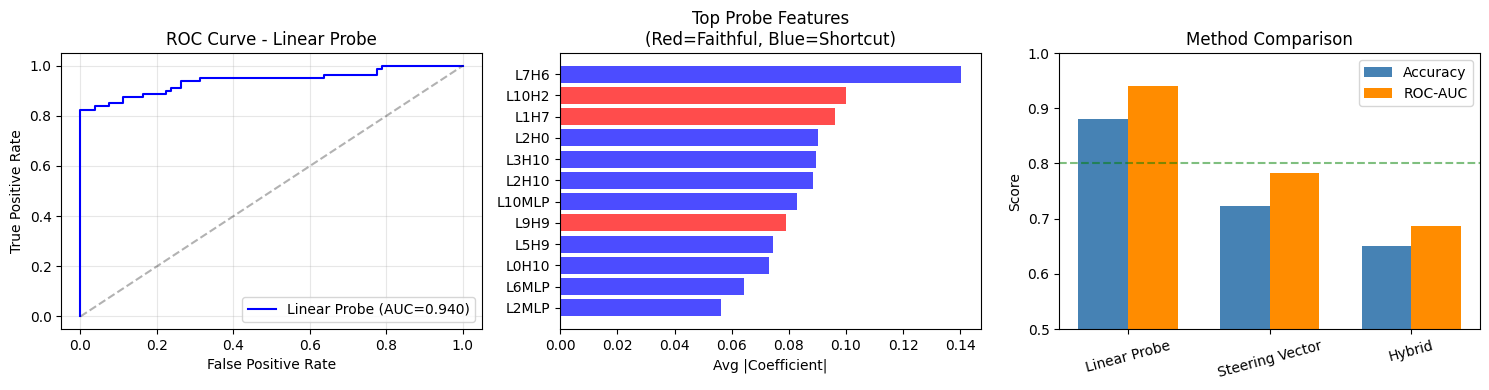

Saved: results/phase2_faithfulness_detector/phase2_comparison.png


In [15]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. ROC curve for linear probe
fpr, tpr, _ = roc_curve(probe_results['y_test'], probe_results['y_prob'])
axes[0].plot(fpr, tpr, label=f"Linear Probe (AUC={probe_results['roc_auc']:.3f})", color='blue')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Linear Probe')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Top feature contributions (probe coefficients)
coef = probe_results['coef']
# Map coefficients to component names
component_coefs = []
start_idx = 0
for comp in KEY_COMPONENTS:
    dim = D_MODEL if comp.endswith("MLP") else D_HEAD
    avg_coef = np.mean(np.abs(coef[start_idx:start_idx + dim]))
    component_coefs.append((comp, avg_coef))
    start_idx += dim

component_coefs.sort(key=lambda x: x[1], reverse=True)
top_comps = component_coefs[:12]

colors = ['red' if c[0] in FAITHFUL_HEADS + FAITHFUL_MLPS else 'blue' for c in top_comps]
axes[1].barh([c[0] for c in top_comps], [c[1] for c in top_comps], color=colors, alpha=0.7)
axes[1].set_xlabel('Avg |Coefficient|')
axes[1].set_title('Top Probe Features\n(Red=Faithful, Blue=Shortcut)')
axes[1].invert_yaxis()

# 3. Method comparison
methods = ['Linear Probe', 'Steering Vector', 'Hybrid']
accuracies = [probe_results['accuracy'], steering_results['accuracy'], hybrid_results['accuracy']]
aucs = [probe_results['roc_auc'], steering_results['roc_auc'], hybrid_results['roc_auc']]

x = np.arange(len(methods))
width = 0.35
axes[2].bar(x - width/2, accuracies, width, label='Accuracy', color='steelblue')
axes[2].bar(x + width/2, aucs, width, label='ROC-AUC', color='darkorange')
axes[2].set_ylabel('Score')
axes[2].set_title('Method Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(methods, rotation=15)
axes[2].legend()
axes[2].set_ylim(0.5, 1.0)
axes[2].axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Target')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'phase2_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {RESULTS_DIR / 'phase2_comparison.png'}")

In [16]:
# Save results
results = {
    'dataset_size': len(all_data),
    'n_faithful': len(faithful_data),
    'n_unfaithful': len(unfaithful_data),
    'key_components': KEY_COMPONENTS,
    'faithful_heads': FAITHFUL_HEADS,
    'shortcut_heads': SHORTCUT_HEADS,
    'faithful_mlps': FAITHFUL_MLPS,
    'shortcut_mlps': SHORTCUT_MLPS,
    'probe_accuracy': probe_results['accuracy'],
    'probe_roc_auc': probe_results['roc_auc'],
    'steering_accuracy': steering_results['accuracy'],
    'steering_roc_auc': steering_results['roc_auc'],
    'hybrid_accuracy': hybrid_results['accuracy'],
    'hybrid_roc_auc': hybrid_results['roc_auc'],
}

with open(RESULTS_DIR / 'phase2_results.json', 'w') as f:
    json.dump(results, f, indent=2)

np.save(RESULTS_DIR / 'steering_vector.npy', steering_vector)
np.save(RESULTS_DIR / 'hybrid_vector.npy', hybrid_vector)
np.save(RESULTS_DIR / 'probe_coefficients.npy', probe_results['coef'])

print(f"\n✓ Results saved to {RESULTS_DIR}")
print(f"  - phase2_results.json")
print(f"  - steering_vector.npy")
print(f"  - hybrid_vector.npy")
print(f"  - probe_coefficients.npy")


✓ Results saved to results/phase2_faithfulness_detector
  - phase2_results.json
  - steering_vector.npy
  - hybrid_vector.npy
  - probe_coefficients.npy


---

## Summary

### What We Built
1. **Linear Probe** on Phase 1.5 circuits → Direct classifier
2. **Steering Vector** on residual stream → Unsupervised direction
3. **Hybrid Vector** on key components → Circuit-grounded direction

### Key Insight
If Path C (Hybrid) beats Path B (Steering), then **Phase 1.5 circuit discovery added value** - the specific heads and MLPs we identified capture faithfulness better than the full residual stream.

### Next Steps
1. **Phase 3**: Use steering vector to *intervene* and force faithful reasoning
2. **Generalization**: Test on different arithmetic formats
3. **Scale up**: Try GPT-2 Medium/Large

---

*Phase 2 of CoT Faithfulness Mechanistic Interpretability*